In [5]:
import torch
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from collections import defaultdict

HOME = Path('/pvc4/battery/nmi_configs')

def mape(x, y):
    return torch.mean((x - y).abs() / y)

In [17]:
workspace =  HOME / 'workspaces/transfer'
preds = defaultdict(dict)
for path in workspace.glob('*'):
    mat, count = path.name.split('_')
    preds_ = []
    for pred_file in path.glob('preds*.pkl'):
        with open(pred_file, 'rb') as f:
            pred = pickle.load(f)
        preds_.append(pred)
    preds[mat][count] = preds_


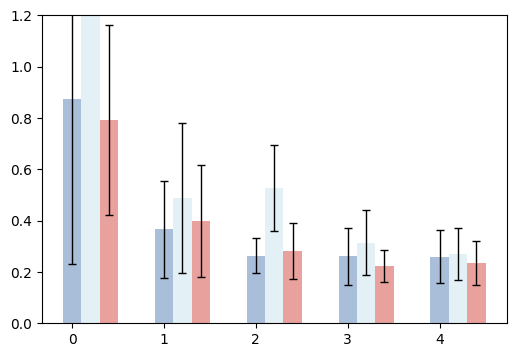

In [20]:
colors = ['#A9BED9', '#E3F0F6', '#E8A19D']
train_counts = {
    'LCO': [1, 2, 4, 8, 16],
    # 'NMC': [1, 2, 4, 8, 16],
    # 'NCA': [1, 2, 4, 8]
}
for material, counts in train_counts.items():
    means, stds, mins, maxs = [], [], [], []
    for count in counts:
        scores = {
            'BatLiNet': [],
            'Finetune': [],
            'Vanilla': []
        }
        for seed in range(8):
            seed_preds = preds[material][str(count)][seed]
            # scores['BatLiNet'].append(mape(
            #     (seed_preds['intercd_preds'] + seed_preds['intracd_preds']) / 2,
            #     seed_preds['labels']
            # ))
            scores['BatLiNet'].append(mape(seed_preds['intercd_preds'], seed_preds['labels']))
            scores['Finetune'].append(mape(seed_preds['finetune_preds'], seed_preds['labels']))
            scores['Vanilla'].append(mape(seed_preds['intracd_preds'], seed_preds['labels']))
        means.append([np.mean(scores[key]) for key in ['Vanilla', 'Finetune', 'BatLiNet']])
        stds.append([np.std(scores[key]) for key in ['Vanilla', 'Finetune', 'BatLiNet']])
        mins.append([np.min(scores[key]) for key in ['Vanilla', 'Finetune', 'BatLiNet']])
        maxs.append([np.max(scores[key]) for key in ['Vanilla', 'Finetune', 'BatLiNet']])
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    x = np.arange(len(counts))
    ax.bar(
        x,
        [i[0] for i in means],
        width=0.2,
        color=colors[0],
        yerr=[i[0] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    ax.bar(
        x+0.2,
        [i[1] for i in means],
        width=0.2,
        color=colors[1],
        yerr=[i[1] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    ax.bar(
        x+0.4,
        [i[2] for i in means],
        width=0.2,
        color=colors[2],
        yerr=[i[2] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    plt.ylim([0, 1.2])
    plt.show()
    # fig.savefig(
    #     HOME / f'workspaces/transfer/{material}.svg',
    #     bbox_inches='tight',
    #     pad_inches=0.1
    # )